# Data Analysis

In [1]:
# Import packages

import sys
import os
from typing import List, Dict, Optional, Tuple, Callable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
from IPython.display import Audio

sys.path.append(os.path.abspath("../src"))
from data_loader import EmotionDataset, DatasetConfig
from utils.visualization import PlotSplitedDataHistogram

import warnings
warnings.filterwarnings ('ignore')
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings(action="ignore"):
    fxn()

In [2]:
# Parameters

DATA_ROOT = "D:\Projects\Technion\EmotionDetection\data"
SR = 6000 # 22050
FIX_SECS = 3
# MAX_FILES = 13000

## Data Info

For the Speech Emotion Recognition (SER) task, several widely used datasets provide diverse audio samples of spoken emotions. Each dataset has distinct characteristics in terms of actors, age ranges, accents, lexical content, and emotional categories. Understanding these differences is crucial for building robust models.

|                        | **RAVDESS** | **TESS** | **CREMAD** | **SAVEE** |
| ---------------------- | ----------- | -------- | ---------- | --------- |
| **Actors**             | 12 Male, 12 Female | 2 Female | 48 Male, 43 Female | 4 Male |
| **Ages**               | 20-60 | 26, 64 | 20-74 | 27-31 |
| **Lexical statements** | 2 | 200 | 12 | 15 |
| **Accent**             | North American | Canadian | African America, Asian, Caucasian, Hispanic | British |
| **Emotion types**      | neutral, calm, happy, sad, angry, fear, disgust, surprise | anger, disgust, fear, happy, surprise, sad, neutral | anger, disgust, fear, happy, neutral, sad | anger, disgust, fear, happy, sad, surprise, neutral |
| **Emotion intesity**   | normal, strong | single | low, medium, high | single |
| **Total samples**      | 1440 | 2800 | 74420 | 480 |


<br /><u>**Observations**</u>

* **Emotion coverage**: <br />All datasets cover core emotions (anger, happiness, sadness, fear, neutral). Some add disgust or surprise, making them complementary.
* **Intensity variation**: <br />RAVDESS and CREMA-D include multiple intensity levels, while TESS and SAVEE use single intensity recordings. This affects how models learn subtle emotional cues.
* **Sample size**: <br />CREMA-D is the largest, while SAVEE is the smallest. RAVDESS is unique for including both speech and song.
* **Demographics**: <br />CREMA-D stands out with diverse ethnic backgrounds, while SAVEE is limited to four British male speakers.


<br /><u>**Handling Strategy**</u><br />
To maximize recognition performance across these datasets:

1) **Emotion alignment**
    * Map emotion labels across datasets to a unified set (e.g., anger, happiness, sadness, fear, neutral).
    * Handle similar categories (e.g., calm and neutral in RAVDESS) by merging or excluding depending on experiment goals.

2) **Intensity normalization**
    * Standardize intensity levels (e.g., treat “normal/strong” and “low/medium/high” as comparable categories).
    * Consider collapsing intensities into a binary scale (low vs. high) for consistency.

3) **Sample balancing**
    * Use data augmentation (pitch shifting, noise injection, time stretching) to balance smaller datasets like SAVEE.
    * Apply class weighting or oversampling to reduce bias from larger datasets.

4) **Cross-dataset training**
    * Train models on combined datasets to improve generalization.
    * Evaluate performance separately on each dataset to measure robustness.

5) **Domain adaptation**
    * Use transfer learning or fine-tuning to adapt models trained on larger datasets (CREMA-D, RAVDESS) to smaller ones (SAVEE).



In [3]:
# Dataset of metadata

ds_cfg = DatasetConfig(
    data_root = DATA_ROOT
)
ds_work = EmotionDataset(ds_cfg)
print(f"Discovered {len(ds_work)} files.")

Discovered 12162 files.


In [4]:
ds = pd.DataFrame({
    "path": ds_work.paths,
    "dataset": ds_work.datasets,
    "emotion": ds_work.emotions,
    "intensity": ds_work.intensities
})
print(ds['dataset'].unique())
print(ds['emotion'].unique())
print(ds['intensity'].unique())
ds

['cremad' 'ravdess' 'savee' 'tess']
[4 6 5 2 0 3 1 7]
['single' 'high' 'low' 'middle' 'normal' 'strong']


,path,dataset,emotion,intensity
0,D:\Projects\Technion\EmotionDetection\data\cre...,cremad,4,single
1,D:\Projects\Technion\EmotionDetection\data\cre...,cremad,6,single
2,D:\Projects\Technion\EmotionDetection\data\cre...,cremad,5,single
3,D:\Projects\Technion\EmotionDetection\data\cre...,cremad,2,single
4,D:\Projects\Technion\EmotionDetection\data\cre...,cremad,0,single
...,...,...,...,...
12157,D:\Projects\Technion\EmotionDetection\data\tor...,tess,3,single
12158,D:\Projects\Technion\EmotionDetection\data\tor...,tess,3,single
12159,D:\Projects\Technion\EmotionDetection\data\tor...,tess,3,single
12160,D:\Projects\Technion\EmotionDetection\data\tor...,tess,3,single


### Emotion Alignment

In [5]:
# Get RAVDESS dataset only
ds_ravdess = ds.where((ds['dataset']=='ravdess')).dropna()

In [6]:
# Listen to a random neutral sample from RAVDESS
ds_ravdess_neutral = ds_ravdess.where((ds_ravdess['emotion']==0)).dropna()
ds_ravdess_neutral_sample = ds_ravdess_neutral.sample(n=1)
sample_path = ds_ravdess_neutral_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(77253,)

In [7]:
# Listen to a random calm sample from RAVDESS
ds_ravdess_calm = ds_ravdess.where((ds_ravdess['emotion']==1)).dropna()
ds_ravdess_calm_sample = ds_ravdess_calm.sample(n=1)
sample_path = ds_ravdess_calm_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(90496,)

In [8]:
# Listen to a random happy sample from RAVDESS
ds_ravdess_happy = ds_ravdess.where((ds_ravdess['emotion']==2)).dropna()
ds_ravdess_happy_sample = ds_ravdess_happy.sample(n=1)
sample_path = ds_ravdess_happy_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(72103,)

In [9]:
# Listen to a random sad sample from RAVDESS
ds_ravdess_sad = ds_ravdess.where((ds_ravdess['emotion']==3)).dropna()
ds_ravdess_sad_sample = ds_ravdess_sad.sample(n=1)
sample_path = ds_ravdess_sad_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(80931,)

In [10]:
# Listen to a random angry sample from RAVDESS
ds_ravdess_angry = ds_ravdess.where((ds_ravdess['emotion']==4)).dropna()
ds_ravdess_angry_sample = ds_ravdess_angry.sample(n=1)
sample_path = ds_ravdess_angry_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(84610,)

In [11]:
# Listen to a random fear sample from RAVDESS
ds_ravdess_fear = ds_ravdess.where((ds_ravdess['emotion']==5)).dropna()
ds_ravdess_fear_sample = ds_ravdess_fear.sample(n=1)
sample_path = ds_ravdess_fear_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(82403,)

In [12]:
# Listen to a random disgust sample from RAVDESS
ds_ravdess_disgust = ds_ravdess.where((ds_ravdess['emotion']==6)).dropna()
ds_ravdess_disgust_sample = ds_ravdess_disgust.sample(n=1)
sample_path = ds_ravdess_disgust_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(91967,)

In [13]:
# Listen to a random surprise sample from RAVDESS
ds_ravdess_surprise = ds_ravdess.where((ds_ravdess['emotion']==7)).dropna()
ds_ravdess_surprise_sample = ds_ravdess_surprise.sample(n=1)
sample_path = ds_ravdess_surprise_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(77989,)

In [14]:
# Get TESS dataset only
ds_tess = ds.where((ds['dataset']=='tess')).dropna()
# Listen to a random disgust sample from TESS
ds_tess_disgust = ds_tess.where((ds_tess['emotion']==6)).dropna()
ds_tess_disgust_sample = ds_tess_disgust.sample(n=1)
sample_path = ds_tess_disgust_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(57410,)

In [15]:
# Get CREMAD dataset only
ds_cremad = ds.where((ds['dataset']=='cremad')).dropna()
# Listen to a random disgust sample from CREMAD
ds_cremad_disgust = ds_cremad.where((ds_cremad['emotion']==6)).dropna()
ds_cremad_disgust_sample = ds_cremad_disgust.sample(n=1)
sample_path = ds_cremad_disgust_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(82403,)

<u>**Conclusion**</u><br/>
- **Calm** – This emotion is acoustically very close to *Neutral*, making it difficult to distinguish even by human perception. To avoid confusion during training and prevent the model from converging toward an ambiguous class, I have chosen to exclude *Calm* from the dataset rather than merge it with *Neutral*.


### Intensity normalisation

In [16]:
# Listen to a random normal sample from RAVDESS
ds_ravdess_normal = ds_ravdess.where((ds_ravdess['intensity']=='normal')).dropna()
ds_ravdess_normal_sample = ds_ravdess_normal.sample(n=1)
sample_path = ds_ravdess_normal_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(82403,)

In [17]:
# Listen to a random strong sample from RAVDESS
ds_ravdess_strong = ds_ravdess.where((ds_ravdess['intensity']=='strong')).dropna()
ds_ravdess_strong_sample = ds_ravdess_strong.sample(n=1)
sample_path = ds_ravdess_strong_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(81667,)

In [18]:
# Listen to a random low sample from CREMAD
ds_cremad_low = ds_cremad.where((ds_cremad['intensity']=='low')).dropna()
ds_cremad_low_sample = ds_cremad_low.sample(n=1)
sample_path = ds_cremad_low_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(48559,)

In [19]:
# Listen to a random middle sample from CREMAD
ds_cremad_middle = ds_cremad.where((ds_cremad['intensity']=='middle')).dropna()
ds_cremad_middle_sample = ds_cremad_middle.sample(n=1)
sample_path = ds_cremad_middle_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(48559,)

In [20]:
# Listen to a random high sample from CREMAD
ds_cremad_high = ds_cremad.where((ds_cremad['intensity']=='high')).dropna()
ds_cremad_high_sample = ds_cremad_high.sample(n=1)
sample_path = ds_cremad_high_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(50766,)

In [21]:
# Listen to a random single sample from CREMAD
ds_cremad_single = ds_cremad.where((ds_cremad['intensity']=='single')).dropna()
ds_cremad_single_sample = ds_cremad_single.sample(n=1)
sample_path = ds_cremad_single_sample['path'].values[0]
sample, sr = librosa.load(sample_path)
display(sample.shape)
Audio(data=sample, rate=sr)

(58859,)

<u>**Conclusion**</u><br/>
Most samples in the datasets lack explicit intensity labels, and even those that are labeled do not consistently reflect a uniform scale of intensity. Because of this inconsistency, I have chosen not to normalize the data based on intensity values, ensuring that the training process focuses on emotion categories rather than unreliable intensity information.

In [22]:
ds_work.clean_data()
print(f"Discovered {len(ds_work)} files.")

ds = pd.DataFrame({
    "path": ds_work.paths,
    "dataset": ds_work.datasets,
    "emotion": ds_work.emotions,
    "intensity": ds_work.intensities
})
print(ds['dataset'].unique())
print(ds['emotion'].unique())
print(ds['intensity'].unique())

Discovered 11970 files.
['cremad' 'ravdess' 'savee' 'tess']
[3 5 4 1 0 2 6]
['single' 'high' 'low' 'middle' 'normal' 'strong']


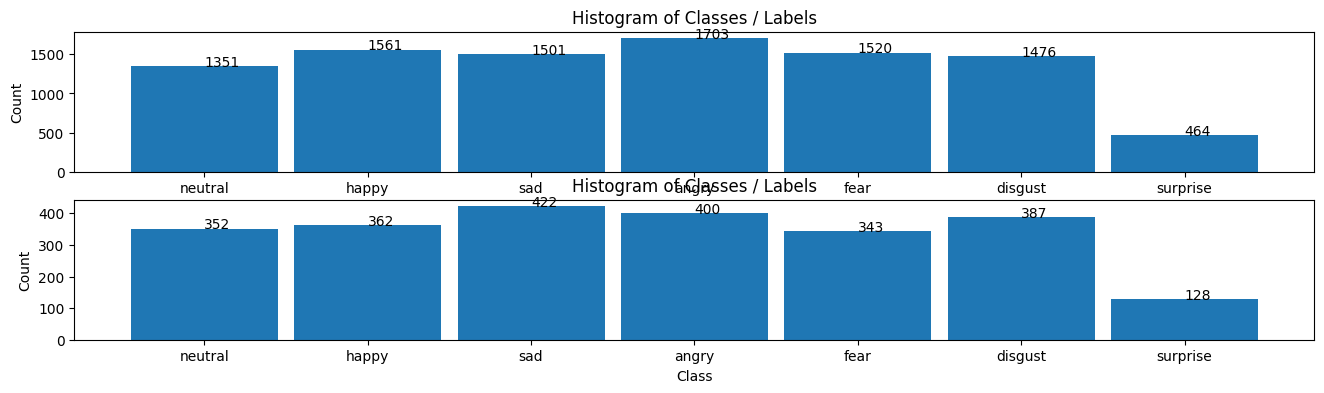

In [ ]:
# Check label balances
train_fs, test_fs, train_labels, test_labels = train_test_split(ds_work.paths, ds_work.emotions, train_size = 0.8, random_state = 512)
labels_list = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
PlotSplitedDataHistogram(train_labels, test_labels, labels_list)